In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')
data_df.head()

training_set  ct_0  ct_1  ct_2  ct_3  ct_4  ct_5  ct_6  ct_7  ct_8  ct_9  \
0          True     0     0     0     1     0     0     0     0     0     0   
1          True     0     0     1     0     0     0     0     0     0     0   
2          True     1     0     0     0     0     0     0     0     0     0   
3          True     0     0     0     1     0     0     0     0     0     0   
4          True     0     1     0     0     0     0     0     0     0     0   

                                         x  
0  AAATACACACTTGCTGCTTCCGGCTCGTATGTTGTGTGG  
1  AAATTTACACTGTATGCTTCCGGCTCGCATGGCGTTTGC  
2  AAATTTACACTTTATGCATCAGACTCGTATGTTGTGTGG  
3  AAATTTACACTTTATGCTTCTGGCGCGTATGCGGCGTGG  
4  AACATTACATTTTATGCTTCCGGCTCGTATGGTGTGTGG

In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=39, Y=10


In [4]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 36,671
testing N: 9,107


In [5]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet='dna',
                     gpmap_type='additive',
                     mpa_hidden_nodes=100)

# Where is ct_n?
model.set_data(x=train_df['x'].values,
               y=train_df[y_cols].values)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

N = 36,671 observations set as training data.
Data shuffled.
Time to set data: 0.433 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    36671 rows  and      156 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      156

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.004e+03  8.891e+05   1.0e+00  8.8e-01
     1  5.76047e-03  5.463e+02  1.683e+04   5.4e-01  2.9e-02  1.1e+03  1.0e+00
     2  4.01461e-02  4.929e+02  4.277e+03   4.9e-01  8.2e-03  1.1e+03  1.5e+01
     3  6.71862e-03  4.853e+02  2.220e+03   4.8e-01  4.3e-03  1.1e+03  2.2e+01
     4 -4.36361e-02  4.825e+02  7.966e+02   4.8e-01  1.6e-03  1.1e+03  2.2e+01
     5 -4.42180e-02  4.825e+02  7.157e+02   4.8e-01  1.4e-03  1.1e+03  2.1e+01
     6 -4.59760e-02  4.823e+02  3.690e+02   4.8e-01  5.2e-04  1.5e+03  2.1e+01
     7 -4.65870e-02  4.822e+02  1.272e+02   4.8e-01  1.8e-04  1

In [6]:
# Save model
model.save('sortseq_mpa_additive')

Model saved to these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


In [7]:
# Load model
model = mavenn.load('sortseq_mpa_additive')

Model loaded from these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


On test data:
I_like_test: 0.340 +- 0.007 bits
I_pred_test: 0.523 +- 0.014 bits


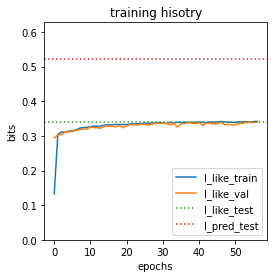

In [8]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

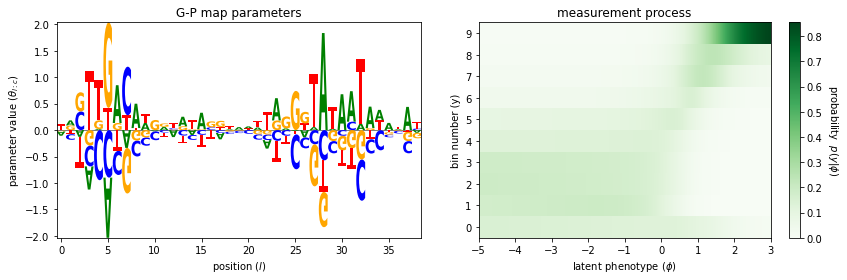

In [9]:
# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_mpa_visualization.png')
plt.show()

In [10]:
# Test simulate_data
sim_df = model.simulate_dataset(N=len(data_df))
sim_df.head()

training_set       phi                                        x  ct_0  \
0          True  0.789972  GGCTTTACGCTTTATGCTGCTGGCTGGTACGTTGTGTGG     0   
1          True  0.011392  GGCTTTTCACTTAATACTCCCGGCTCGTATGGTGTGTGG     0   
2          True  1.333577  ATCTTTACACGTTATGCTTCCGGCTGCTATGTTGTTTGG     1   
3          True -0.622586  GCCAGTACAATTTATGCTTCCGGCTCGTATTTTGTGTGG     0   
4          True  0.892200  ATCTTTACAATATGTGCTTCCGGCTCGTATCTTGTGTGG     0   

   ct_1  ct_2  ct_3  ct_4  ct_5  ct_6  ct_7  ct_8  ct_9  
0     0     0     0     0     0     0     0     1     0  
1     0     1     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     1     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     1     0

In [11]:
# Split into trianing and test data
ix = sim_df['training_set']
L = len(sim_df['x'][0])
sim_train_df = sim_df[ix]
print(f'sim training N: {len(sim_train_df):,}')
sim_test_df = sim_df[~ix]
print(f'sim testing N: {len(sim_test_df):,}')

sim training N: 36,609
sim testing N: 9,169


In [12]:
# Define model
sim_model = mavenn.Model(regression_type='MPA',
                       L=L,
                       Y=Y,
                       alphabet='dna',
                       gpmap_type='additive',
                       mpa_hidden_nodes=100)

# Where is ct_n?
sim_model.set_data(x=sim_train_df['x'].values,
                   y=sim_train_df[y_cols].values)

# Fit model to data
sim_model.fit(learning_rate=.005,
              epochs=1000,
              batch_size=500,
              early_stopping=True,
              early_stopping_patience=10,
              linear_initialization=True)

N = 36,609 observations set as training data.
Data shuffled.
Time to set data: 0.461 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    36609 rows  and      156 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      156

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  9.837e+02  8.632e+05   1.0e+00  8.9e-01
     1  5.38381e-03  5.454e+02  1.592e+04   5.5e-01  2.8e-02  1.1e+03  1.0e+00
     2  1.20613e-02  4.957e+02  4.183e+03   5.0e-01  8.0e-03  1.1e+03  1.5e+01
     3 -3.77727e-02  4.884e+02  2.167e+03   5.0e-01  4.2e-03  1.1e+03  2.2e+01
     4 -1.04230e-01  4.858e+02  7.509e+02   4.9e-01  1.5e-03  1.1e+03  2.2e+01
     5 -1.06526e-01  4.856e+02  5.524e+02   4.9e-01  1.1e-03  1.1e+03  2.1e+01
     6 -1.07994e-01  4.855e+02  3.731e+02   4.9e-01  5.5e-04  1.4e+03  2.1e+01
     7 -1.08794e-01  4.855e+02  1.287e+02   4.9e-01  1.8e-04  1

On test data:
I_intr_like: 0.304 +- 0.008 bits
I_intr_pred: 0.311 +- 0.011 bits
I_like_test: 0.296 +- 0.009 bits
I_pred_test: 0.307 +- 0.013 bits


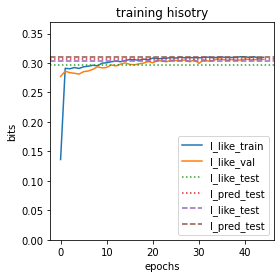

In [14]:
# Show training history
print('On test data:')
x_test = sim_test_df['x'].values
y_test = sim_test_df[y_cols].values

# Compute the intrinsic information using the true model
I_intr_like, dI_intr_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_intr_like: {I_intr_like:.3f} +- {dI_intr_like:.3f} bits') 

I_intr_pred, dI_intr_pred =  model.I_predictive(x=x_test, y=y_test)
print(f'I_intr_pred: {I_intr_pred:.3f} +- {dI_intr_pred:.3f} bits') 

# Compute likelihood information
I_like, dI_like =  sim_model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = sim_model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = sim_model.history['I_like']
val_I_like_hist = sim_model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr_like, color='C4', linestyle='--', label='I_like_test')
ax.axhline(I_intr_pred, color='C5', linestyle='--', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);